# Imports

In [ ]:
!pip install contractions

     |████████████████████████████████| 321 kB 8.1 MB/s 
     |████████████████████████████████| 284 kB 20.8 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85458 sha256=77d72c78c7abee2221ffb2602541ef4b0aac2ae098ee62ad2c9475d3b04a18b4
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [ ]:
!pip install -U pip setuptools wheel
!pip install -U spacy

     |████████████████████████████████| 1.7 MB 7.8 MB/s 
     |████████████████████████████████| 952 kB 39.8 MB/s 
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


     |████████████████████████████████| 6.0 MB 6.3 MB/s            
     |████████████████████████████████| 10.1 MB 37.9 MB/s            
     |████████████████████████████████| 42 kB 1.5 MB/s             
     |████████████████████████████████| 628 kB 44.7 MB/s            
     |████████████████████████████████| 181 kB 34.2 MB/s            
     |████████████████████████████████| 451 kB 48.9 MB/s            
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uni

In [ ]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 777.4 MB 6.6 kB/s             
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
import pandas as pd
import spacy
import re
import contractions
import string
import collections

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

%cd drive
%cd MyDrive
%cd Colab Notebooks
%cd Innopolis DS
%cd Opinion mining

Mounted at /content/drive
/content/drive
/content/drive/MyDrive
/content/drive/MyDrive/Colab Notebooks
/content/drive/MyDrive/Colab Notebooks/Innopolis DS
/content/drive/MyDrive/Colab Notebooks/Innopolis DS/Opinion mining


# Functions

In [ ]:
def clean_text(text):

    text=re.sub(r"\?", ".", text)
    text=re.sub(r"\!", ".", text)
    text=re.sub(r'([.])\1+', r'\1', text)
    rexp=r"\.(?=[A-Za-z]{1,15})"
    text=re.sub(rexp, ". ", text)
    text=re.sub(r'\s+([.,"])', r'\1', text)
    text=re.sub(r" '", "'", text)
    text=re.sub(r" n't", "n't", text)
    text = text.translate(str.maketrans(' ',' ',string.punctuation))
    text=re.sub(r'([ ])\1+', r'\1', text)
    text = contractions.fix(text)
    text = text.lower()
    
    return text


def get_verb_adv_chunks(df_no_dupl):
    
    product_names = df_no_dupl['product'].unique().tolist()
    product_features = {}

    for name in product_names:
        product_df = df_no_dupl[df_no_dupl['product'] == name].reset_index(drop=True)
        chunk_list = []
        review_list = []

        for i in range(len(product_df)):
            text = clean_text(product_df.iloc[i,0])
            doc = nlp(text)
            
            for word in doc:
                if word.pos_ == 'ADV' and word.head.pos_ == 'VERB':
                    negative = ''
                    relevant_chunk = True
                    
                    for child in word.head.children:
                        if child.dep_ == 'neg':
                            negative = child.text
                        elif child.dep_ == 'dobj':
                            relevant_chunk = False
                            
                    if relevant_chunk:
                        if negative != '':
                            result_chunk = ' '.join([negative, word.text, word.head.text])
                        else:
                            result_chunk = ' '.join([word.text, word.head.text])

                        chunk_list.append(result_chunk)
                        review_list.append(text)
                        
        product_features[name] = [chunk_list, review_list]
        
    return product_features


def get_adj_noun_chunks(df_no_dupl):
    
    product_names = df_no_dupl['product'].unique().tolist()
    product_features = {}

    for name in product_names:
        product_df = df_no_dupl[df_no_dupl['product'] == name].reset_index(drop=True)
        chunk_list = []
        review_list = []

        for i in range(len(product_df)):
            text = clean_text(product_df.iloc[i,0])
            doc = nlp(text)
            
            for word in doc:
                if word.pos_ == 'ADJ' and word.head.pos_ == 'NOUN':
                    
                    if word.lemma_ not in stop_adjs and word.head.lemma_ not in stop_nouns:
                    
                        negative = ''
                        if word.head.head.pos_ == 'VERB':

                            for child in word.head.head.children:
                                if child.dep_ == 'neg':
                                    negative = child.text

                        if negative != '':
                            result_chunk = ' '.join([negative, word.text, word.head.text])
                        else:
                            result_chunk = ' '.join([word.text, word.head.text])

                        chunk_list.append(result_chunk)
                        review_list.append(text)
                    
        product_features[name] = [chunk_list, review_list]
        
    return product_features


def get_noun_be_adj_chunks(df_no_dupl):
    
    product_names = df_no_dupl['product'].unique().tolist()
    product_features = {}

    for name in product_names:
        product_df = df_no_dupl[df_no_dupl['product'] == name].reset_index(drop=True)
        chunk_list = []
        review_list = []

        for i in range(len(product_df)):
            text = clean_text(product_df.loc[i,'review'])
            doc = nlp(text)
            
            for word in doc:
                if word.pos_ == 'AUX':
                    subject = ''
                    adjective = ''
                    negative = ''

                    for child in word.children:
                        if child.dep_ == 'nsubj' and child.pos_ == 'NOUN' and child.lemma_ not in stop_nouns:
                            subject = child.text
                            for grandchild in child.children:
                                if grandchild.dep_ == 'compound':
                                    subject = ' '.join([grandchild.text, subject])
                        if child.dep_ == 'acomp' and child.lemma_ not in stop_adjs:
                            adjective = child.text
                        if child.dep_ == 'neg':
                            negative = child.text

                    if len(subject) > 0 and len(adjective) > 0:
                        if negative != '':
                            result_chunk = ' '.join([negative, adjective, subject])
                        else:
                            result_chunk = ' '.join([adjective, subject])
                            
                        chunk_list.append(result_chunk)
                        review_list.append(text)
                        
        product_features[name] = [chunk_list, review_list]
        
    return product_features


def aggregate_repeated_chunks(current_product, product_features):

    current_cunks = product_features[current_product][0]
    print(f'{current_product} ({len(current_cunks)} chunks)')

    chunk_count = {i:current_cunks.count(i) for i in current_cunks}
    sorted_top = sorted(chunk_count.items(), key=lambda x: x[1], reverse=True)
    
    return sorted_top


def aggregate_similar_chunks(chunk_count_agg):
    
    all_similar_items = []
    similar_items_extended = []
    indx_to_skip = []

    for i in range(len(chunk_count_agg)):
        
        if i not in indx_to_skip:
            
            item1 = chunk_count_agg[i]
            similar_items = []
            probably_similar_items = []
            probably_similar_items_indx = []

            for j in range(i+1, len(chunk_count_agg)):
                
                if j not in indx_to_skip:
                    item2 = chunk_count_agg[j]
                    
                    if nlp(item1[0]).similarity(nlp(item2[0])) >= 0.8 and nlp(item1[0]).similarity(nlp(item2[0])) != 1:
                        for x in range(item2[1]):
                            similar_items.append(item2[0])
                        indx_to_skip.append(j)

                    elif nlp(item1[0]).similarity(nlp(item2[0])) >= 0.7 and nlp(item1[0]).similarity(nlp(item2[0])) != 1:
                        for x in range(item2[1]):
                            probably_similar_items.append(item2[0])
                            probably_similar_items_indx.append(j)

            if similar_items:

                for j in range(item1[1]):
                    similar_items.append(item1[0])

                similar_items_extended = similar_items

                if probably_similar_items:

                    for j in range(len(probably_similar_items)):
                        candidate = probably_similar_items[j]
                        distance = 0
                        
                        for item in similar_items:
                            distance += nlp(candidate).similarity(nlp(item))
                            
                        mean_distance = distance/len(similar_items)
                        
                        if mean_distance >= 0.8:
                            similar_items_extended.append(candidate)
                            indx_to_skip.append(probably_similar_items_indx[j])

                similar_items_count = {x:similar_items_extended.count(x) for x in similar_items_extended}
                similar_items_count = sorted(similar_items_count.items(), key=lambda x: x[1], reverse=True)

            else:
                single_item = []
                for j in range(item1[1]):
                    single_item.append(item1[0])

                similar_items_count = {x:single_item.count(x) for x in single_item}
                similar_items_count = sorted(similar_items_count.items(), key=lambda x: x[1], reverse=True)

            all_similar_items.append(similar_items_count)
        
    return all_similar_items


def remove_repeated_chunks(all_similar_items):

    indx_to_skip = []
    all_similar_items_cleaned = []

    for i in range(len(all_similar_items)):
        if i not in indx_to_skip:
            for j in range(i+1, len(all_similar_items)):
                if j not in indx_to_skip:
                    if collections.Counter(all_similar_items[i]) == collections.Counter(all_similar_items[j]):
                        indx_to_skip.append(j)
                        
            all_similar_items_cleaned.append(all_similar_items[i])
            
    return all_similar_items_cleaned


def make_aspect_review_df(current_product, product_features, all_similar_items_cleaned):


    current_chunk_list = product_features[current_product][0]
    current_review_list = product_features[current_product][1]

    items_and_sentences = pd.DataFrame(list(zip(current_chunk_list, current_review_list)),
                   columns =['aspect', 'review'])

    result_df = []
    
    for item in all_similar_items_cleaned:
        temp_items = []

        for sub_item in item:
            temp_items.append(sub_item[0])

        temp_df = items_and_sentences[items_and_sentences['aspect'].isin(temp_items)].reset_index(drop=True)
        main_item = pd.DataFrame(temp_df['aspect'].value_counts())['aspect'].idxmax()
        count = len(temp_df)

        for sub_item in item:
            temp_df = items_and_sentences[items_and_sentences['aspect'] == sub_item[0]].reset_index(drop=True)

            for i in range(len(temp_df)):
                temp = {}
                temp['review'] = temp_df.loc[i, 'review']
                temp['aspect'] = temp_df.loc[i, 'aspect']
                temp['key_aspect'] = main_item
                temp['count'] = count
                result_df.append(temp)

    result_df = pd.DataFrame(result_df)
    result_df = result_df.sort_values(['count', 'key_aspect'], ascending=False).reset_index(drop=True)
    result_df['product'] = current_product

    return result_df

# Main

In [ ]:
fast = False

if fast:
  datasets = ['data/5 products 2004/Apex AD2600 Progressive-scan DVD player.txt']
else:
  datasets = ['data/5 products 2004/Apex AD2600 Progressive-scan DVD player.txt',
            'data/5 products 2004/Canon G3.txt',
            'data/5 products 2004/Creative Labs Nomad Jukebox Zen Xtra 40GB.txt',
            'data/5 products 2004/Nikon coolpix 4300.txt',
            'data/5 products 2004/Nokia 6610.txt',
            'data/9 products 2008/Canon PowerShot SD500.txt',
            'data/9 products 2008/Canon S100.txt',
            'data/9 products 2008/Diaper Champ.txt',
            'data/9 products 2008/Hitachi router.txt',
            'data/9 products 2008/ipod.txt',
            'data/9 products 2008/Linksys Router.txt',
            'data/9 products 2008/MicroMP3.txt',
            'data/9 products 2008/Nokia 6600.txt',
            'data/9 products 2008/norton.txt']

In [ ]:
reviews = []
borders = []
temp_border = 0

for dataset in datasets:
    
    with open(dataset) as f:
        review = f.readlines()
        
    reviews += review
    temp_border += len(review)
    borders.append(temp_border)

In [ ]:
products = []

for i in range(len(datasets)):
    temp = {}
    temp['row_num'] = borders[i]
    temp['product_name'] = datasets[i].split('/')[-1].split('.')[0]
    products.append(temp)

In [ ]:
data = []
tags_to_remove = ['[t]', '[u]', '[p]', '[s]', '[cc]', '[cs]']
product_num = 0
current_product = products[product_num]

for i in range(len(reviews)):
    temp = {}
    
    if i == current_product['row_num']:
        product_num += 1
        current_product = products[product_num]
        
    if any(tag in reviews[i] for tag in tags_to_remove):
        continue
    else:
        item = reviews[i].split('##')
        text = item[1].replace("\n", "").strip()
        keys = item[0].split(',')

        if keys[0] != '':
            for key in keys:
                temp = {}
                aspect = re.sub(r"\[.]", "", key).strip()
                aspect = aspect.replace('[+', '_1_')
                aspect = aspect.replace('[-', '_0_')

                temp['review'] = text
                temp['aspect'] = aspect.split('_')[0]
                temp['sentiment'] = aspect.split('_')[1]
                temp['product'] = current_product['product_name']
                data.append(temp)
            
df = pd.DataFrame(data)
df.sentiment = df.sentiment.astype(int)

In [ ]:
df

,review,aspect,sentiment,product
0,im a more happier person after discovering the...,i/p button,1,Apex AD2600 Progressive-scan DVD player
1,"but , if you 're looking for my opinion of the...",dvd player,1,Apex AD2600 Progressive-scan DVD player
2,i 've had the player for about 2 years now and...,player,1,Apex AD2600 Progressive-scan DVD player
3,i 've had the player for about 2 years now and...,sound,0,Apex AD2600 Progressive-scan DVD player
4,for the price it is a well spent investment !,price,1,Apex AD2600 Progressive-scan DVD player
...,...,...,...,...
3711,I had tried to uninstall Norton Internet Secur...,uninstall,0,norton
3712,"Of course, if you try to reach Symantec custom...",Symantec customer service,0,norton
3713,"This time, it started the uninstallation proce...",uninstallation,0,norton
3714,"I simply hate Symantec. I swear, if I could ha...",Symantec,0,norton


In [ ]:
product_names = df['product'].unique().tolist()

Total number of aspects: 3716
Positive: 2448
Negative: 1268


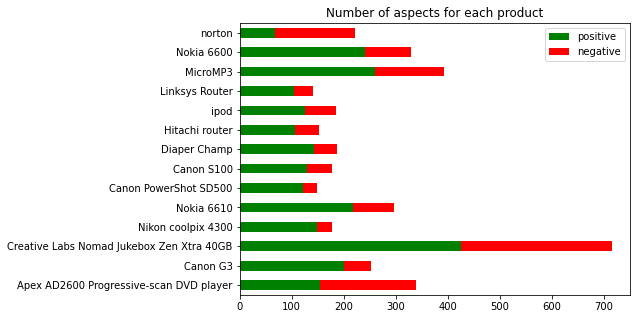

In [ ]:
stats = []
for product in product_names:
  temp = {}
  temp['product'] = product
  temp_df = df[df['product'] == product]
  temp['positive'] = len(temp_df[temp_df['sentiment'] == 1])
  temp['negative'] = len(temp_df[temp_df['sentiment'] == 0])
  stats.append(temp)

stats = pd.DataFrame(stats)
stats.set_index('product', inplace = True)

print(f'Total number of aspects: {len(df)}')
print(f'Positive: {df.sentiment.value_counts()[1]}')
print(f'Negative: {df.sentiment.value_counts()[0]}')

ax = stats.plot.barh(
    rot=0, stacked=True,
    color={"positive": "green", "negative": "red"},
    xlabel='', title = 'Number of aspects for each product',
    figsize=(7, 5))

In [ ]:
df_no_dupl = df.drop_duplicates(subset=['review'])
print(f'{len(df_no_dupl)} unique sentences')

3076 unique sentences


In [ ]:
nlp = spacy.load('en_core_web_lg')
stop_words = nlp.Defaults.stop_words

stop_words.remove('no')
stop_words.remove('not')
stop_words.remove('none')

stop_nouns = ['thing', 'hour', 'day', 'week', 'moment', 'times', 'occasions', 'reviews', 'one', 'number', ]
stop_adjs = ['other', 'most', 'different', 'few']

In [ ]:
# Getting all potential product features (aspects)

product_features1 = get_adj_noun_chunks(df_no_dupl)
product_features2 = get_noun_be_adj_chunks(df_no_dupl)

product_features = {}
for name in product_names:
    chunk_list = product_features1[name][0]+product_features2[name][0]
    review_list = product_features1[name][1]+product_features2[name][1]
    product_features[name] = [chunk_list, review_list]

In [ ]:
result_df = pd.DataFrame()

for i in range(len(product_names)):
    
    print(f'Preparing data for product {i+1}/{len(product_names)}')
    current_product = product_names[i]
    
    chunk_count_agg = aggregate_repeated_chunks(current_product, product_features)
    
    print('Aggregating similar chunks...')
    all_similar_items = aggregate_similar_chunks(chunk_count_agg)
    
    print('Removing repeated chunks...')
    all_similar_items_cleaned = remove_repeated_chunks(all_similar_items)
    
    print('Creating dataframe...')
    if result_df.empty:
        result_df = make_aspect_review_df(current_product, product_features, all_similar_items_cleaned)
    else:
        current_result_df = make_aspect_review_df(current_product, product_features, all_similar_items_cleaned)
        result_df = pd.concat([result_df, current_result_df])
    print('')

Preparing data for product 1/14
Apex AD2600 Progressive-scan DVD player (206 chunks)
Aggregating similar chunks...
Removing repeated chunks...
Creating dataframe...

Preparing data for product 2/14
Canon G3 (308 chunks)
Aggregating similar chunks...
Removing repeated chunks...
Creating dataframe...

Preparing data for product 3/14
Creative Labs Nomad Jukebox Zen Xtra 40GB (660 chunks)
Aggregating similar chunks...
Removing repeated chunks...
Creating dataframe...

Preparing data for product 4/14
Nikon coolpix 4300 (205 chunks)
Aggregating similar chunks...
Removing repeated chunks...
Creating dataframe...

Preparing data for product 5/14
Nokia 6610 (296 chunks)
Aggregating similar chunks...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:173: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:178: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.


Removing repeated chunks...
Creating dataframe...

Preparing data for product 6/14
Canon PowerShot SD500 (208 chunks)
Aggregating similar chunks...
Removing repeated chunks...
Creating dataframe...

Preparing data for product 7/14
Canon S100 (164 chunks)
Aggregating similar chunks...
Removing repeated chunks...
Creating dataframe...

Preparing data for product 8/14
Diaper Champ (138 chunks)
Aggregating similar chunks...
Removing repeated chunks...
Creating dataframe...

Preparing data for product 9/14
Hitachi router (114 chunks)
Aggregating similar chunks...
Removing repeated chunks...
Creating dataframe...

Preparing data for product 10/14
ipod (176 chunks)
Aggregating similar chunks...
Removing repeated chunks...
Creating dataframe...

Preparing data for product 11/14
Linksys Router (113 chunks)
Aggregating similar chunks...
Removing repeated chunks...
Creating dataframe...

Preparing data for product 12/14
MicroMP3 (367 chunks)
Aggregating similar chunks...
Removing repeated chunks.

In [ ]:
result_df

,review,aspect,key_aspect,count,product
0,i was impressed by this very inexpensive playe...,inexpensive player,best player,16,Apex AD2600 Progressive-scan DVD player
1,i looked into buying an inexpensive dvd player...,inexpensive player,best player,16,Apex AD2600 Progressive-scan DVD player
2,this is the best dvd player i have purchased,best player,best player,16,Apex AD2600 Progressive-scan DVD player
3,i think apex is the best dvd player you can ge...,best player,best player,16,Apex AD2600 Progressive-scan DVD player
4,for the first few weeks this player was everyt...,affordable player,best player,16,Apex AD2600 Progressive-scan DVD player
...,...,...,...,...,...
162,i give it 4stars only because the installation...,average user,average user,1,norton
163,this program would not let me send outlook ema...,audible books,audible books,1,norton
164,i am an advanced computer user so i cannot eve...,advanced user,advanced user,1,norton
165,i do not know what is happened to norton but 2...,absolute garbage,absolute garbage,1,norton


In [ ]:
if fast:
  result_df.to_csv('data/reviews_preprocessed_cut.csv', index=False)
else:
  result_df.to_csv('data/reviews_preprocessed.csv', index=False)

Total number of aspects: 3359


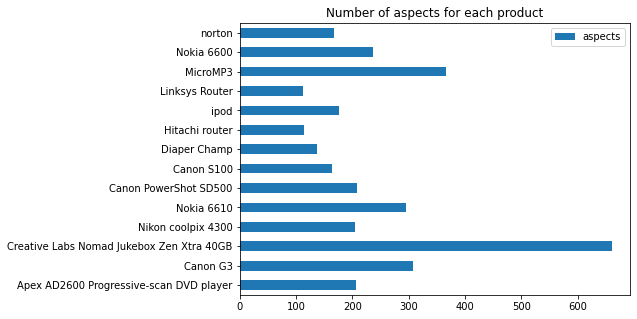

In [ ]:
stats2 = []
for product in product_names:
  temp = {}
  temp['product'] = product
  temp_df = result_df[result_df['product'] == product]
  temp['aspects'] = len(temp_df)
  stats2.append(temp)

stats2 = pd.DataFrame(stats2)
stats2.set_index('product', inplace = True)

print(f'Total number of aspects: {len(result_df)}')

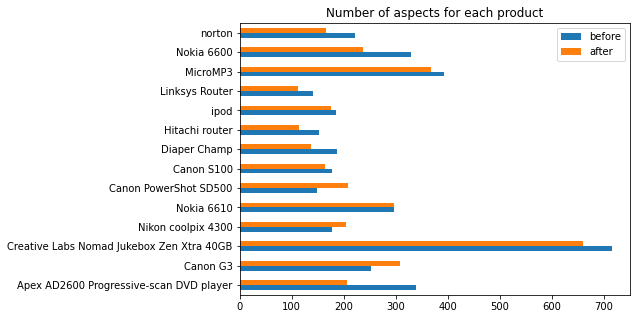

In [ ]:
# Comparing number of aspects of original dataset with extracted aspects

stats['before'] = stats['positive'] + stats['negative'] # original
stats ['after'] = stats2['aspects'] # extracted

ax = stats.plot.barh(
    rot=0,
    y = ['before', 'after'],
    xlabel='', title = 'Number of aspects for each product',
    figsize=(7, 5))